# Hands on: Interacting with human-curated networks in pathway databases

In [12]:
!pip install -q -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
streamlit 1.30.0 requires pandas<3,>=1.3.0, but you have pandas 1.2.5 which is incompatible.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
xarray 2023.6.0 requires pandas>=1.4, but you have pandas 1.2.5 which is incompatible.


## 1. Introduction

### Recap - Example Dataset 1

We use an example dataset produced from an MSstats differential abundance analysis.  This dataset is a small molecule dataset with known inhibition targets.  It includes 8 small molecule inhibitors and a control DMSO holdout. 

### Experimental Factors:
| Treatment    | Nominal target |
| :-------- | :------- |
| DMSO  | Control    |
| VTP50469  | MEN1    |
| PF477736 | Chk1    |
| Jakafi    | JAK1/2    |
| K-975  | TEAD1   |
| VE-821 | ATR    |
| dBET6    | BRD2/3/4   |




Next, we look up one of the drugs in a number of databases

In [1]:
import gilda
gilda.ground('Jakafi')[0].term

Term(jakafi,Jakafi,CHEBI,CHEBI:66917,ruxolitinib phosphate,synonym,chebi,None,None,None)

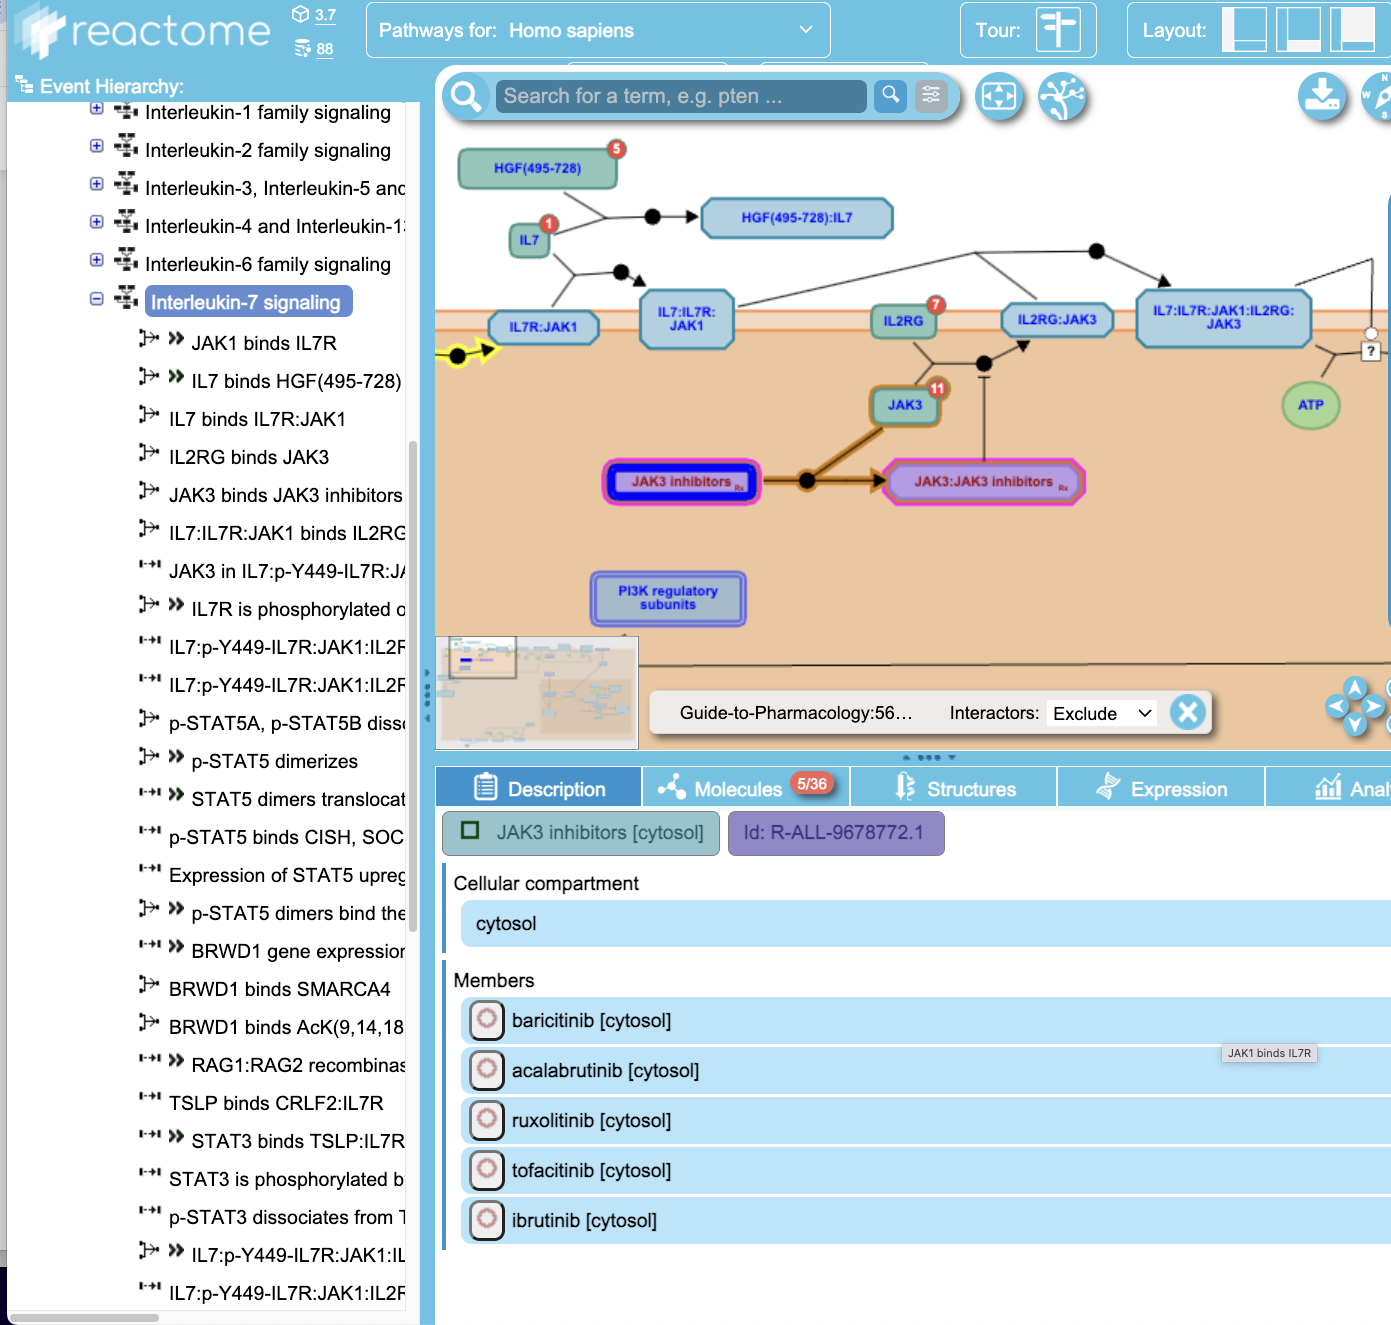

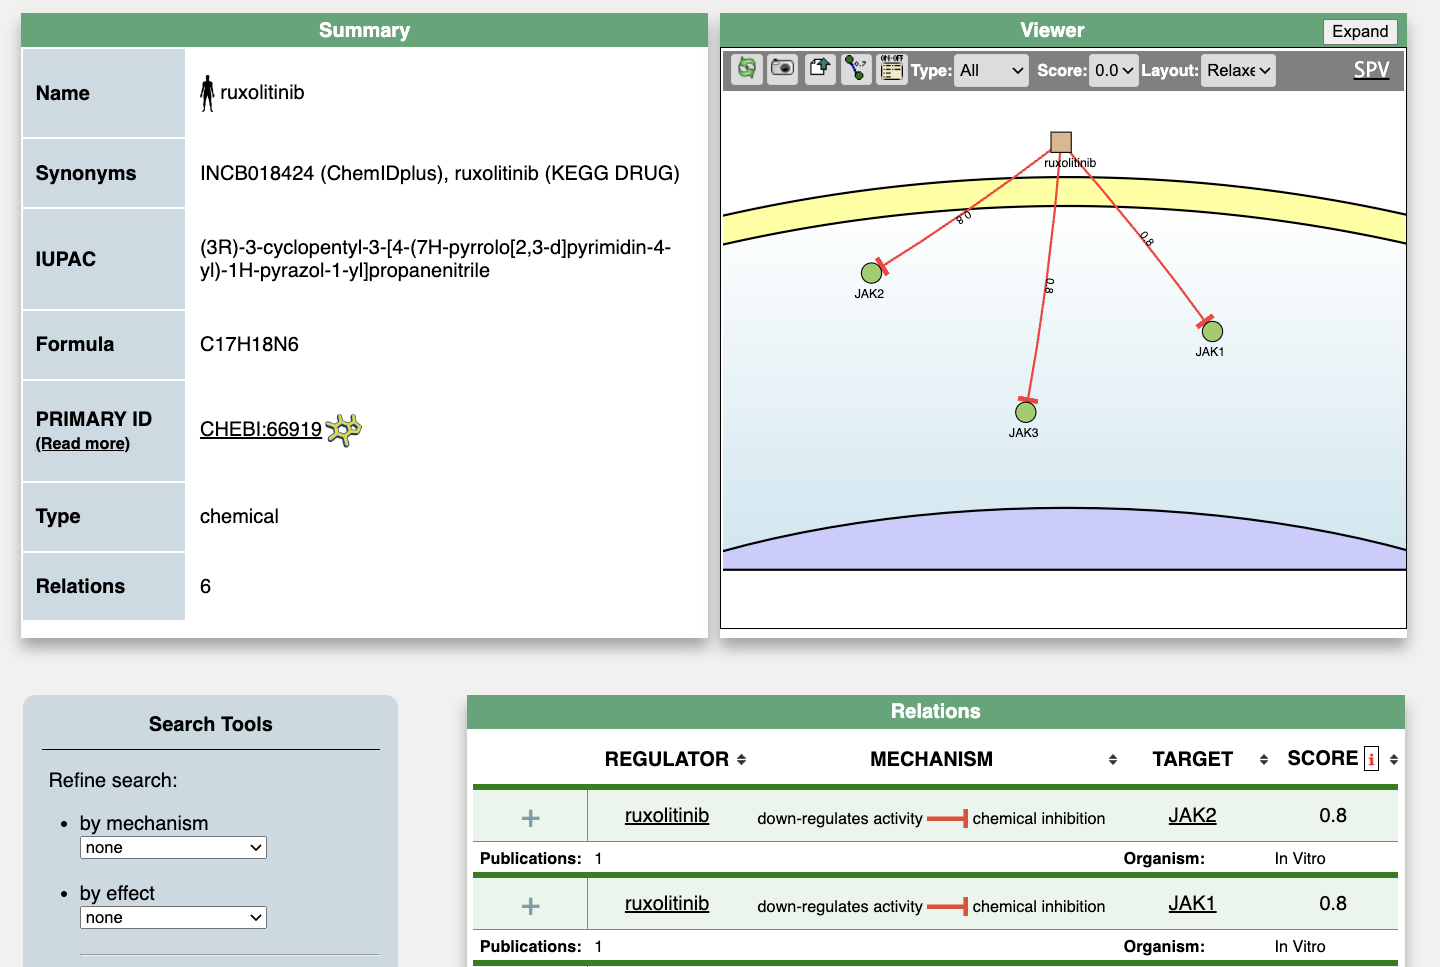

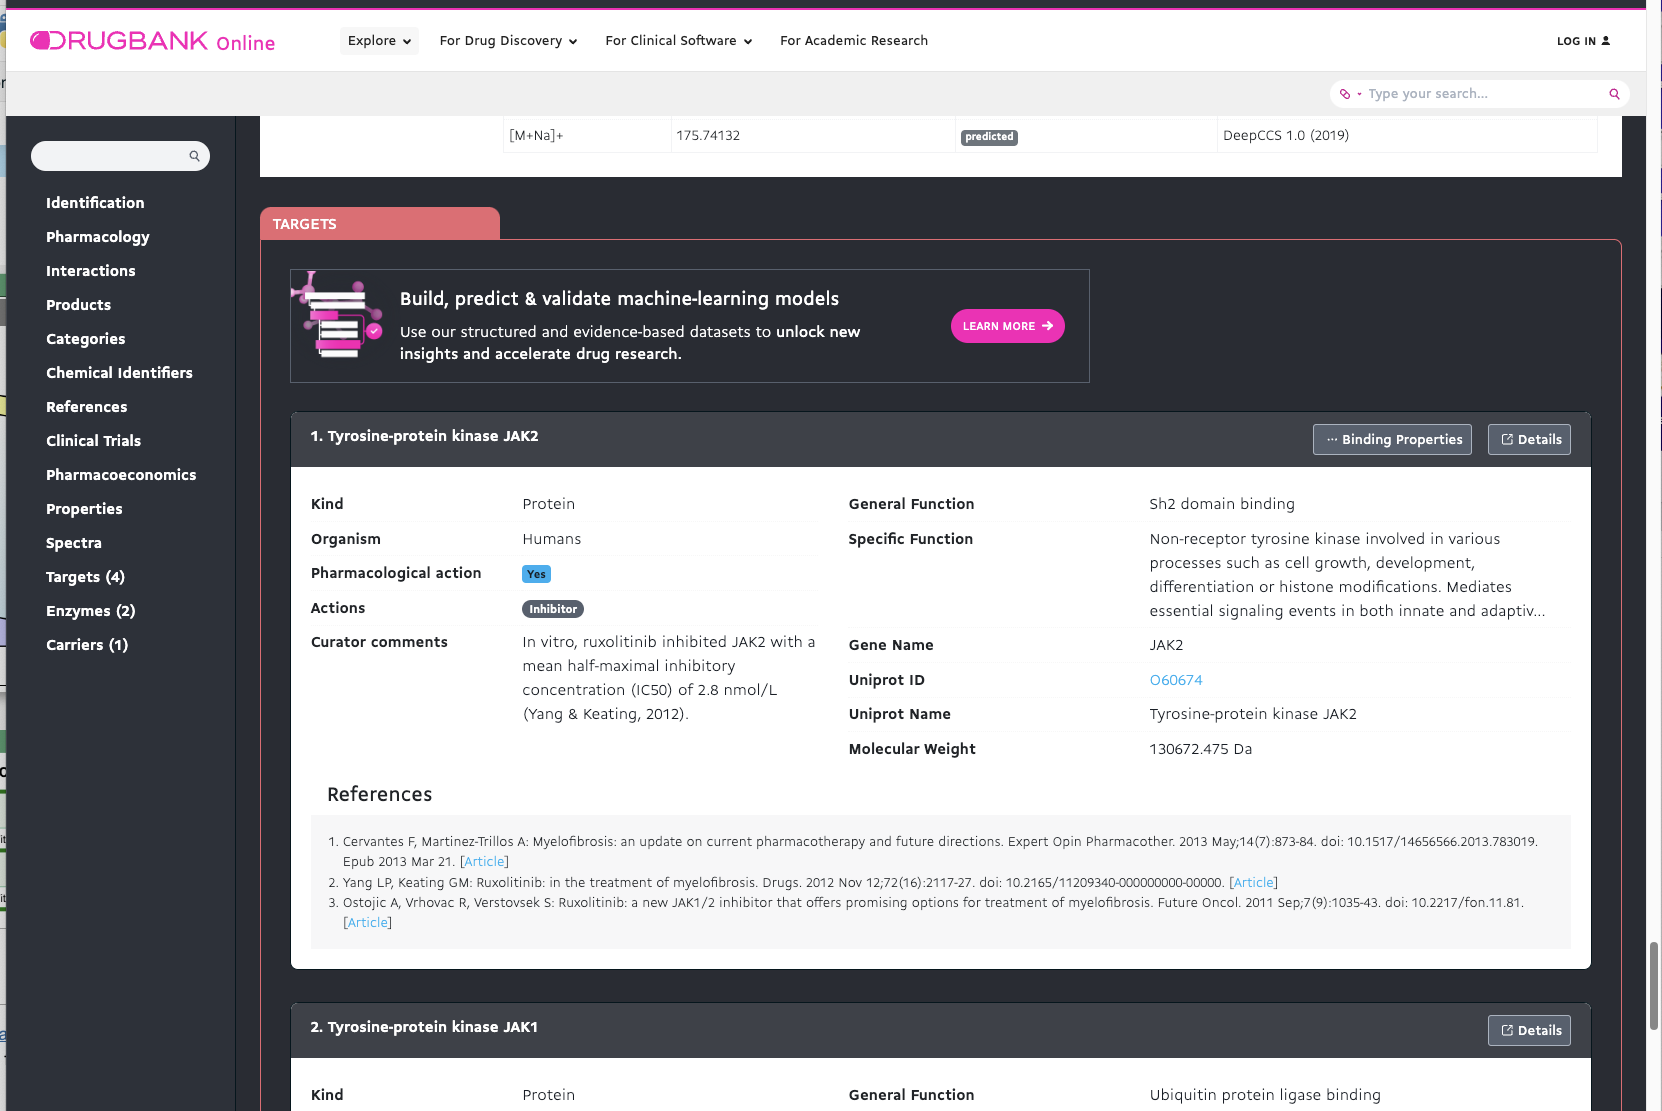

Pathway Commons SIF export download - i.e., two levels of granularity: BioPAX and SIF

## 2. How can we query pathway data from a pathway database?

Our next goal is to demonstrate how we can pull pathway data from a pathway database. For instance, we could take one of the drugs or one of the proteins in our dataset, and query PathwayCommons for its neighborhood.

We will focus on the dataset for drug PF477736

In [2]:
import pandas as pd

P_VALUE_LOGFC_PATH = "model.csv" # Set this path yourself
LABELS_FILTER = ["DMSO-PF477736"]
P_VALUE_FILTER = 0.05 # Adjust this yourself

def construct_pvalue_logfc_df(filename):
    """Return a filtered data frame from the given data file."""
    pandas_df = pd.read_csv(filename)
    pandas_df = pandas_df[pandas_df['issue'].isnull()]
    pandas_df = pandas_df[pandas_df['adj.pvalue'] < P_VALUE_FILTER]
    pandas_df = pandas_df[pandas_df['Label'].isin(LABELS_FILTER)]
    return pandas_df

pvalue_logfc_df = construct_pvalue_logfc_df(P_VALUE_LOGFC_PATH)

Protein          Label        log2FC        SE    Tvalue     DF  \
32541    CLH1_HUMAN  DMSO-PF477736  -0.269783556  0.056036 -4.814489  260.0   
63546   FCGRN_HUMAN  DMSO-PF477736  -0.674851051  0.132991 -5.074427  179.0   
115656  NECP2_HUMAN  DMSO-PF477736   0.693700535  0.097077  7.145875  259.0   
152151   RFA1_HUMAN  DMSO-PF477736   -0.60382375  0.076190 -7.925239  260.0   

              pvalue    adj.pvalue issue  MissingPercentage  \
32541   2.506764e-06  3.094600e-03   NaN           0.143333   
63546   9.674775e-07  1.592468e-03   NaN           0.195918   
115656  9.076739e-12  2.241047e-08   NaN           0.040000   
152151  6.705747e-14  3.311298e-10   NaN           0.120667   

        ImputationPercentage  
32541                    0.0  
63546                    0.0  
115656                   0.0  
152151                   0.0

PyBioPAX implements the BioPAX level 3 object model (http://www.biopax.org/release/biopax-level3-documentation.pdf) as a set of Python classes. It exposes API functions to read OWL files into this object model, and to dump OWL files from this object model. This allows for the processing and creation of BioPAX models natively in Python.

Gyori BM, Hoyt CT (2022). PyBioPAX: biological pathway exchange in Python. Journal of Open Source Software, 7(71), 4136, https://doi.org/10.21105/joss.04136

In [2]:
import pybiopax

We can query for the neighborhood around CHEK1 stored in pathway commons.  We should expect that the small molecule associated with CHEK1 should be in the neighborhood.

In [6]:
model = pybiopax.model_from_pc_query('neighborhood', ['CHEK1'])

Processing OWL elements:   0%|          | 0.00/127k [00:00<?, ?it/s]

In [7]:
model.objects.get('SmallMolecule_ddc4ef4f078db1f02d605c5fe94003b9')

SmallMolecule(PF 00477736)

We can query for biological entities that are in pathways from CHEK1 and CLTC.  We choose CLTC since it is a differentially abundant protein for the PF 00477736 experiment

In [11]:
model = pybiopax.model_from_pc_query('pathsfromto', ['CHEK1'], target=['CLTC'], limit=6)
len(model.objects)

Processing OWL elements:   0%|          | 0.00/3.82k [00:00<?, ?it/s]

3816